In [1]:
import os
import random
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Set some parameters
im_width = 256
im_height = 256
border = 5
path_train = "DataDSB18/train/"
path_test = "DataDSB18/test/"
path_KB = "Images/"

Using TensorFlow backend.


In [2]:
print(path_train + "images")
print("DataDSB18/train/images")

DataDSB18/train/images
DataDSB18/train/images


In [3]:
##def get_pred_data(path):
##    ids= next(os.walk(path))[2]
##    Xp = np.zeros((len(ids), 2048, 2048, 1), dtype=np.float32)
##
##    for n,id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
##        #load image
##        img = load_img(path+id_, grayscale=True)
##        x_img = img_to_array(img)
##        x_img = resize(x_img, (2048, 2048, 1), mode='constant', preserve_range=True)
##        Xp[n,...,0] = x_img.squeeze()/255
##
##        return  Xp
##Xp = get_pred_data(path_KB)


In [4]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (256, 256, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
            mask = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X

X, y = get_data(path_train, train=True)

Getting and resizing images ... 

Done!


C:\anaconda\envs\ImageSegmentation\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  
C:\anaconda\envs\ImageSegmentation\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [5]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

C:\anaconda\envs\ImageSegmentation\lib\site-packages\ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


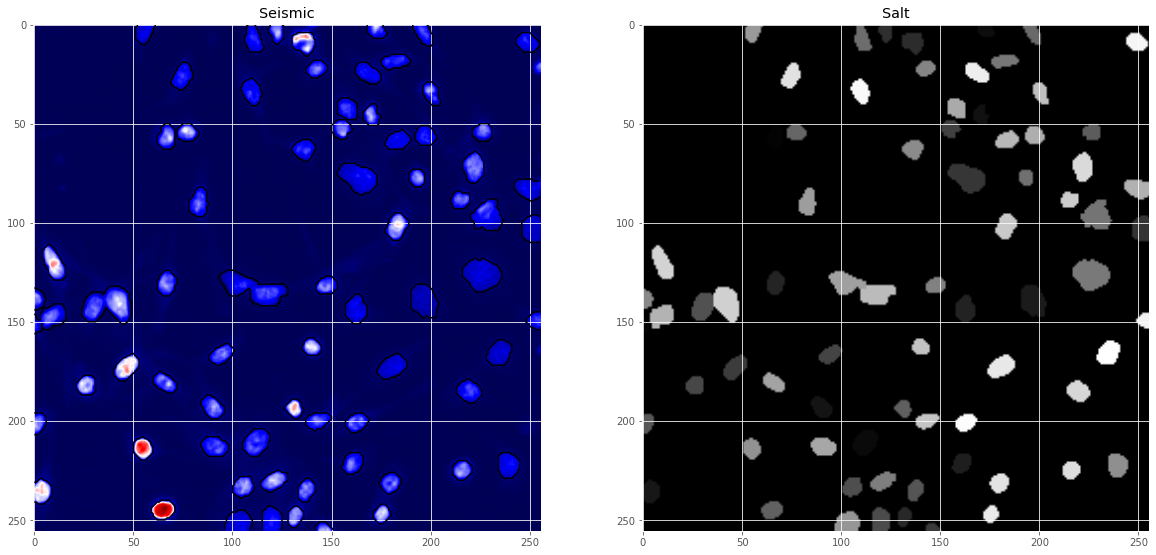

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');


In [7]:

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [8]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [9]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.15, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (A

In [10]:
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 2018
bs = 8

image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)


In [11]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-dsb-cell.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [12]:
#old one
#results = model.fit(X_train, y_train, batch_size=8, epochs=15, callbacks=callbacks,
 #                   validation_data=(X_valid, y_valid))
results = model.fit_generator(train_generator, steps_per_epoch=(len(X_train) // bs), epochs=10, callbacks=callbacks,
                              validation_data=(X_valid, y_valid))


Epoch 1/10
47/47 [==============================] - 16s 350ms/step - loss: 0.7147 - accuracy: 0.5099 - val_loss: 0.4711 - val_accuracy: 0.8760

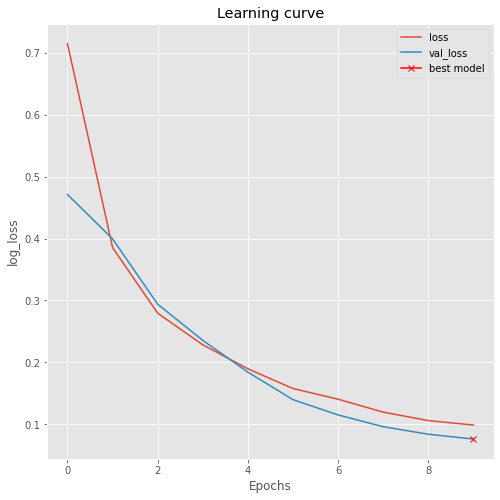

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [14]:
model.load_weights('model-dsb-cell.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

68/68 [==============================] - 2s 26ms/step


[0.07624942677862503, 0.8760977387428284]

In [15]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
# Turns pixels to zero for non-cells and 1 for cells
preds_train_t = (preds_train > 0.1).astype(np.uint8)
preds_val_t = (preds_val > 0.1).astype(np.uint8)

68/68 [==============================] - 0s 6ms/step


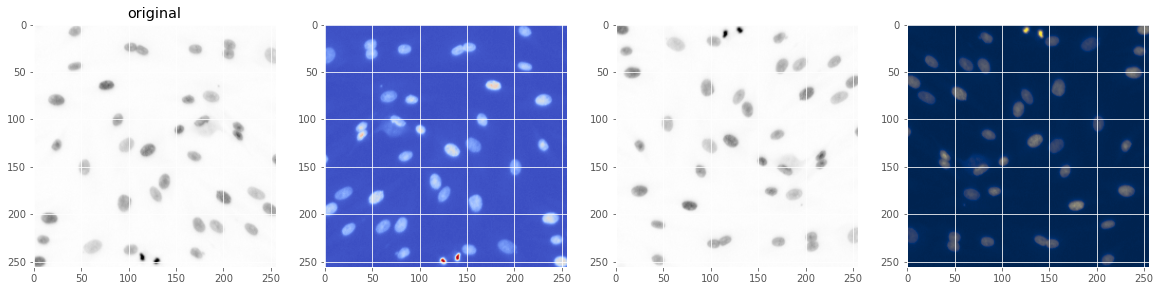

In [23]:
def show_flipped_images(x):
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(x[:,:,0], cmap='binary')
    ax[0].set_title('original')
    ax[1].imshow(np.fliplr(x[:,:,0]), cmap='coolwarm')
    ax[2].imshow(np.flipud(x[:,:,0]), cmap='binary')
    ax[3].imshow(np.fliplr(np.flipud(x[:,:,0])), cmap='cividis')

show_flipped_images(X_train[14])

In [17]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Cells')

    ax[1].imshow(y[ix].squeeze(), cmap='coolwarm')
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask: #colors='k',
        ax[2].contour(y[ix].squeeze(),  levels=[0.5], cmap='coolwarm')
    ax[2].set_title('Cells Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1,cmap='coolwarm')
    if has_mask: #colors='k',
        ax[3].contour(y[ix].squeeze(),  levels=[0.5])
    ax[3].set_title('Cells Predicted binary');


def plot_prediction(X,binary_preds, preds, ix=None):
    if ix is None:
        ix = random.randint(0,len(X))

    fig, ax = plt.subplots(1,3, figsize=(20,10))
    ax[0].imshow(X[ix, ...,0], cmap='coolwarm')
    ax[0].set_title('InputImage')

    ax[1].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1,cmap='binary')
    ax[1].set_title('Predicted Cells Binary Threshold')


    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1,cmap='binary')
    ax[2].set_title('Predicted Cells')

C:\anaconda\envs\ImageSegmentation\lib\site-packages\ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.
C:\anaconda\envs\ImageSegmentation\lib\site-packages\ipykernel_launcher.py:18: UserWarning: No contour levels were found within the data range.
C:\anaconda\envs\ImageSegmentation\lib\site-packages\ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


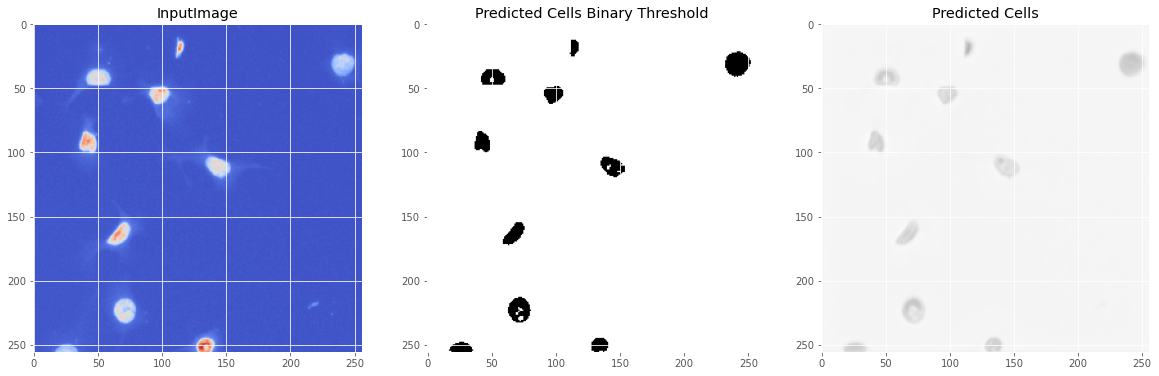

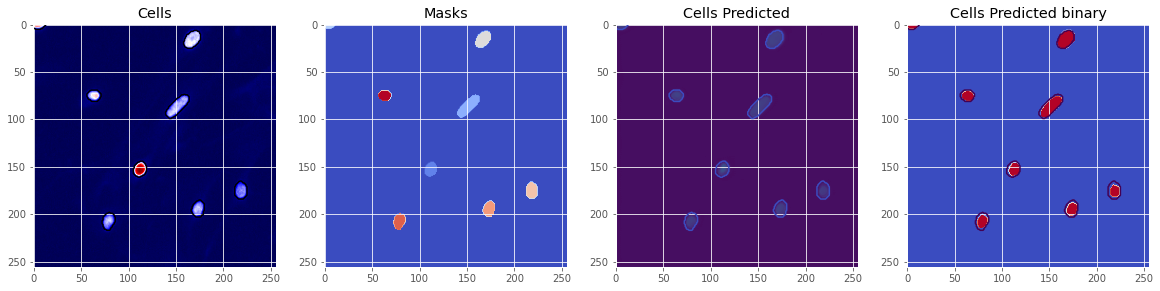

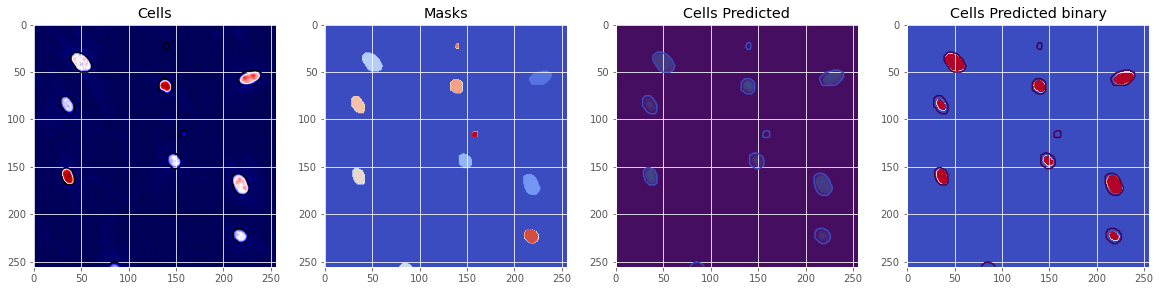

In [18]:
#Try out different colormaps to see the values
plot_prediction(X_train,preds_train_t, preds_train)


# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t)

# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [19]:
#predict using TimeTestAugmentation wrapper
from TTA_ModelWrapper import  TTA_ModelWrapper
tta_model = TTA_ModelWrapper(model)

preds_val_tta = tta_model.predict(X_valid)
preds_train_tta = tta_model.predict(X_train)
#check if any of the values pre-trheshold is over .5


C:\anaconda\envs\ImageSegmentation\lib\site-packages\ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.
C:\anaconda\envs\ImageSegmentation\lib\site-packages\ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.
C:\anaconda\envs\ImageSegmentation\lib\site-packages\ipykernel_launcher.py:28: UserWarning: No contour levels were found within the data range.


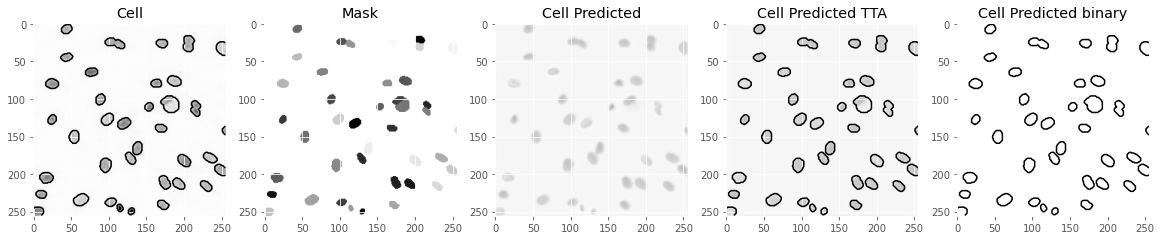

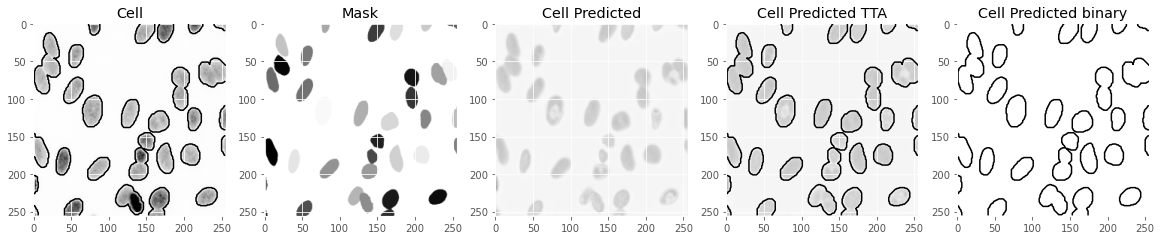

In [20]:
def plot_sample(X, y, preds, preds_tta, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 5, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='binary')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Cell')

    ax[1].imshow(y[ix].squeeze(), cmap='binary')
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1,  cmap='binary')
   # if has_mask:
    #    ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Cell Predicted')

    ax[3].imshow(preds_tta[ix].squeeze(), vmin=0, vmax=1, cmap='binary')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Cell Predicted TTA')

    ax[4].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='binary')
    if has_mask:
        ax[4].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[4].set_title('Cell Predicted binary');

    # Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_tta, preds_train_tta>0.5, ix=14)

# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_tta, preds_val_tta>0.5, ix=19)
